# Sampling Monte Carlo

## Introduction

We want to generate samples of a given density, $f(x)$. In this case, we can assume we already have a reliable way to generate samples from a uniform distribution, $\mathcal{U}[0,1]$. How do we know a random sample ($v$) comes from the $f(x)$ distribution? One way to think about it is that a histogram of samples must approximate $f(x)$. This means that 

$$ \mathbb{P}( v \in N_{\Delta}(x) )  = f(x) \Delta x$$

which says that the probability that a sample is in some $\Delta$ neighborhood of x is approximately $f(x)\Delta x$. 

Let's consider how to create these samples for both discrete and continuous random variables.

## Inverse CDF Method for Discrete Variables

Suppose we have a probability mass function,

$$ f(x) = \sum p_i \delta(x-x_i) $$

where $p_i$ is the probability *mass* at the point $x_i$. For example, for a fair six-sided die, we have

$$ f(x) = \frac{1}{6} \sum_{i=1}^6 \delta(x-i) $$

This generates the corresponding cumulative mass function,

$$ F(x) = \frac{1}{6} \sum_{i=1}^6 U(x-i) $$

where $U$ is the unit-step function. The next block of code develops this using `sympy`.

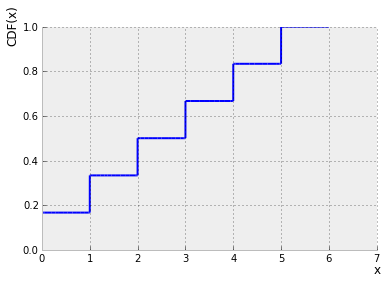

In [ ]:
import sympy as S
x=S.symbols('x')
F = sum([S.Heaviside(x-i+1) for i in range(1,7)])/6 # offset to satisfy sympy definition
S.plot(F,(x,0,6),ylabel='CDF(x)',xlabel='x');

Now, we want a random number generator that outputs an element of $\left \{  1,2,3,..,6\right \} $ with equal probability. We can generate a uniform random variable and think of it as picking a point on the y-axis of the plot above. Then, all we do is pick the corresponding x-axis value as the output. Let's do this in the next code block

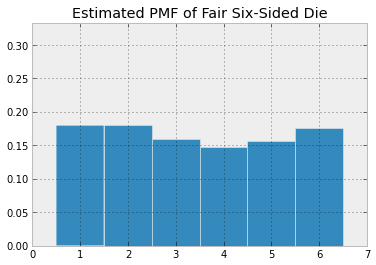

In [ ]:
invF=S.Piecewise((1,0<x<=1/6),    # if uniform sample between 0 and 1/6, choose die-side labeled 1
                 (2,1/6<x<=2/6),
                 (3,2/6<x<=3/6),
                 (4,3/6<x<=4/6),
                 (5,4/6<x<=5/6),
                 (6,5/6<x<=1))

samples=array([invF.subs(x,i) for i in  rand(500)])
hist(samples,bins=[1,2,3,4,5,6,7],normed=1,align='left');
axis(ymax=2/6.)
title('Estimated PMF of Fair Six-Sided Die');

For comparison, here is the estimated CDF compared with $F$. You can trying using more or fewer samples in `rand()` to see how this changes.

(0.0, 7.0, 0.0, 1.1)

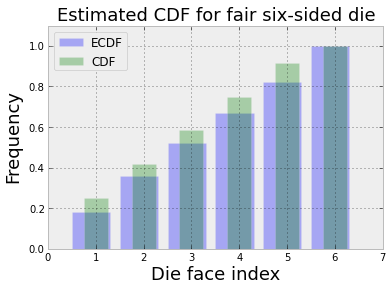

In [ ]:
bar(-.5+arange(1,7),cumsum([mean(samples==i) for i in range(1,7)]),alpha=.3,label='ECDF')   # estimated CDF
bar(-.25+arange(1,7),[F.subs(x,i).evalf() for i in range(1,7)],fc='g',alpha=.3,width=.5,label='CDF') # target CDF
legend(loc=0)
title('Estimated CDF for fair six-sided die',fontsize=18)
ylabel('Frequency',fontsize=18)
xlabel('Die face index',fontsize=18)
axis(ymax=1.1)

By repeating the same argument, we can construct an *unfair* six-sided die as


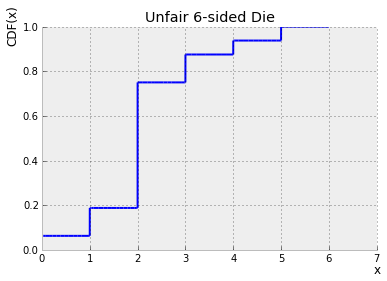

In [ ]:
p = array([1,2,9,2,1,1]) # the faces 2,4 and more probable than 1,5,6 and 3 is the most probable
p = p/sum(p) # normalize to 1
Fu = sum([S.Heaviside(x-i+1)*p[i-1] for i in range(1,7)])
S.plot(Fu,(x,0,6),ylabel='CDF(x)',xlabel='x',title='Unfair 6-sided Die');

In the next block, we automate computing the inverse.

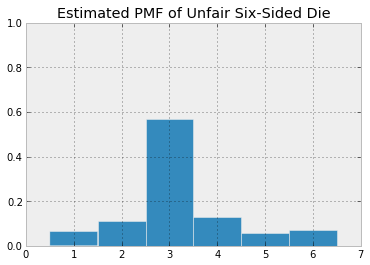

In [ ]:
cp=cumsum([0]+p.tolist()) # need to find edges on vertical axis, add [0] to get left edge
invFu=S.Piecewise(*[(i,j<x<=k) for i,j,k in zip(range(1,7),cp[:-1],cp[1:])])
hist([invFu.subs(x,i) for i in  rand(1000)],bins=[1,2,3,4,5,6,7],normed=1,align='left');
axis(ymax=1.)
title('Estimated PMF of Unfair Six-Sided Die');

## Inverse CDF Method for Continuous Variables

The same idea applies to continuous random variables, but now we have to use squeeze the  intervals down to individual points. In the example above, our inverse function was a piecewise function that operated on uniform random samples. In this case, the piecewise function collapses to a continuous inverse function. 

We want to generate random samples for a CDF $F$ that is invertible. The criterion for generating an appropriate sample is the following,

$$ \mathbb{P}(F(x) < v < F(x+\Delta x)) =  F(x+\Delta x) - F(x) = \int_x^{x+\Delta x} f(u) du \approx  f(x) \Delta x$$

which is saying that the probability that the sample $v$ is contained in a $\Delta x$ interval is approximately equal to the density function, $f(x) \Delta x$ at that point. The trick is to use a uniform random sample ($u$) and an invertible CDF $F(x)$ to construct these samples.

Note that for a uniform random variable $u \sim \mathcal{U}[0,1]$, we have,

$$ \mathbb{P}(x < F^{-1}(u) < x+\Delta x) =\mathbb{P}(F(x) < u < F(x+\Delta x)) =  F(x+\Delta x) - F(x) = \int_x^{x+\Delta x} f(p) dp \approx  f(x) \Delta x$$

This means that $ v=F^{-1}(u) \sim f $, which is what we were after. Let's try this with the exponential distribution,

$$ f_{\alpha}(x) = \alpha\exp(-\alpha x) $$

with the following CDF,

$$ F(x) = 1-\exp(-\alpha x )$$

and corresponding inverse,

$$ F^{-1}(u)  = \frac{1}{\alpha}\ln \frac{1}{(1-u)}$$ 

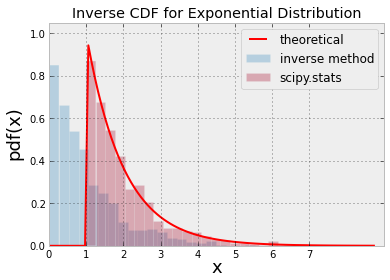

In [ ]:
import scipy.stats

alpha = 1.
nsamp = 1000

u=scipy.stats.uniform(0,1)
x=scipy.stats.expon(alpha)

Finv=lambda u: 1/alpha*log(1/(1-u))
#Finv=lambda u: 1+1/alpha*log(1/(1-u)) # shift over to correct
    
fig,ax = subplots()

xhat = array(map(Finv,u.rvs(nsamp)))
# exponential distrib samples by inverse method
ax.hist(xhat,normed=1,bins=30,alpha=0.3,label='inverse method') 
# exponential distrib samples by scipy.stats
xrvs = x.rvs(nsamp)
xe = linspace(0,xrvs.max(),100)
ax.hist(xrvs,bins=30,normed=1,alpha=0.3,label='scipy.stats')
# exponential theoretical density function
ax.plot(xe,x.pdf(xe),'r-',label='theoretical')
ax.set_xticks(range(int(xrvs.max())))
ax.axis(ymax=1.05)
ax.set_title('Inverse CDF for Exponential Distribution')
ax.set_ylabel('pdf(x)',fontsize=18)
ax.set_xlabel('x',fontsize=18)
ax.legend();

The reason the histogram is shifted over is because we lose knowledge of a constant shift in $v$ because $1-v$ is also uniformly distributed between $\mathcal{U}[0,1]$. This means we have to change the inverse function to the following:

$$ F^{-1}(u)  = 1+\frac{1}{\alpha}\ln \frac{1}{(1-u)}$$ 

## Rejection Method

In some cases, you may not be able to invert for the CDF. The `rejection` method can handle this situation. The idea is to pick a uniform ($\mathcal{U}[a,b]$) random variable $u_1$ and $u_2$ so that

$$ \mathbb{P}\left( u_1 \in N_{\Delta}(x) \bigwedge u_2 < \frac{f(u_1)}{M} \right) \hspace{0.5em} \approx \frac{\Delta x}{b-a} \frac{f(u_1)}{M} $$

where we take $u_1=x$ and $f(x) < M $. The only job of the $M$ variable is to scale down the $f(x)$ so that the $u_2$ variable can span the range.  The *efficiency* of this method is the probability of not rejecting $u_1$ which comes from integrating out the above approximation.

$$ \int dx \frac{f(x)}{M} \hspace{0.5em} = \frac{1}{M(b-a)}$$

This means that we don't want an unecessarily large $M$ because that makes it more likely that samples will be discarded. Let's use a density that does not have a continuous inverse. 

$$ f(x) = \exp\left(-\frac{(x-1)^2}{2x} \right) \hspace{1em}  (x+1)/12 $$ 

where $x>0$. Note that this does not *exactly* integrate out to one like a good probability density function should, but I probably need to think of a better function because the normalization constant for this is pretty convoluted.

Nevertheless, here it is with its corresponding CDF.

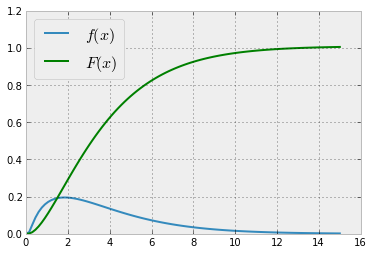

In [ ]:
x = linspace(0.001,15,100)
fig,ax=subplots()
f= lambda x: exp(-(x-1)**2/2./x)*(x+1)/12.
fx = f(x)
ax.plot(x,fx,label='$f(x)$')
ax.plot(x,cumsum(fx)*diff(x)[0],'g',label='$F(x)$')
ax.legend(loc=0,fontsize=16);

And, following our rejection plan, the following are the simulated random samples of $f$.

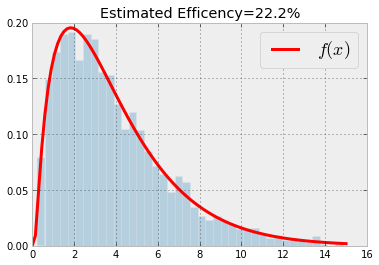

In [ ]:
M=.3 # scale factor
u1 = rand(10000)*15 # uniform random samples scaled out
u2 = rand(10000)    # uniform random samples
idx=where(u2<=f(u1)/M)[0] # rejection criterion
v = u1[idx]

fig,ax=subplots()
ax.hist(v,normed=1,bins=40,alpha=.3)
ax.plot(x,fx,'r',lw=3.,label='$f(x)$')
ax.set_title('Estimated Efficency=%3.1f%%'%(100*len(v)/len(u1)))
ax.legend(fontsize=18)

The plot above shows a pretty good match between our target density function, $f$, and our histogram of the samples we just generated using the rejection method.

Conceptually, there's nothing wrong with this result. The problem is the efficiency is low -- we are throwing away too many samples, as shown in the figure below. We need to somehow do better.

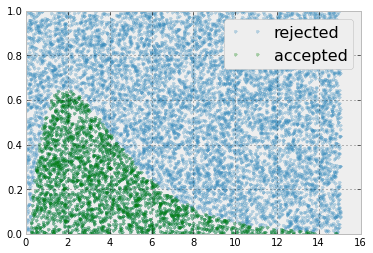

In [ ]:
fig,ax=subplots()
ax.plot(u1,u2,'.',label='rejected',alpha=.3)
ax.plot(u1[idx],u2[idx],'g.',label='accepted',alpha=.3)
ax.legend(fontsize=16)

The above shows the samples that were accepted and rejected by this method. The fact that we threw out so many is very inefficient, and we want to do better.

The above argument uses $u_1$ to select along the domain of $f(x)$ and the other $u_2$ uniform random variable  decides whether to accept or not. One idea would be to choose $u_1$ so that $x$ values are coincidentally those that are near the peak of $f(x)$, instead of uniformly anywhere in the domain, especially near the tails, which are low probability anyway. Now, the trick is to find a new density function $g(x)$ to sample from that has a similiar concentration of probability density. One way it to familiarize oneself with the popular density functions that have adjustable parameters and fast random sample generators already. There are lots of places to look and, chances are, there is likely already such a generator for your problem. Otherwise, the [family of $\beta$ densities](http://en.wikipedia.org/wiki/Beta_distribution) is a good place to start looking. 

To be explicit, what we want is $u_1 \sim g(x) $ so that, returning to our earlier argument,

$$ \mathbb{P}\left( u_1 \in N_{\Delta}(x) \bigwedge u_2 < \frac{f(u_1)}{M} \right) \approx g(x) \Delta x \frac{f(u_1)}{M} $$

but this is *not* what we need here. The problem is with the second part of the $\bigwedge$ clause. We need to put something there that will give us something proportional to $f(x)$. Define the following:

$$ h(x) = \frac{f(x)}{g(x)}$$ 

with corresponding maximum on the domain as $h_{\max}$ and then go back and construct the second part of the clause as

$$ \mathbb{P}\left( u_1 \in N_{\Delta}(x) \bigwedge u_2 < \frac{h(u_1)}{h_{\max}} \right) \approx g(x) \Delta x \frac{h(u_1)}{h_{\max}} = f(x)/h_{\max} $$

Recall that satisfying this criterion means that $u_1=x$. As before, we can estimate the probability of acceptance of the $u_1$ as $ 1/h_{\max}$.

Now, to construct such a $g(x)$ function. Here,we choose the chi-squared distribution. The following plots the $g(x)$ and $f(x)$ (left plot) and the corresponding $h(x)=f(x)/g(x)$ (right plot). Note that $g(x)$ and $f(x)$ have peaks that almost coincide, which is what we are looking for.

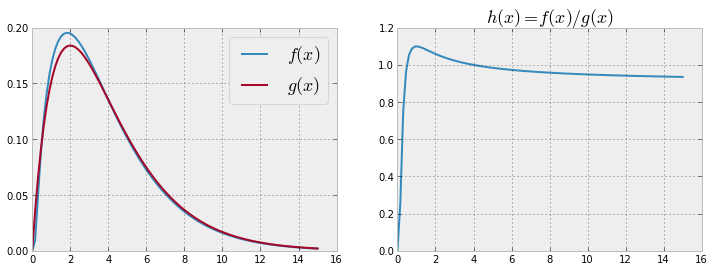

In [ ]:
ch=scipy.stats.chi2(4) # chi-squared
h = lambda x: f(x)/ch.pdf(x) # h-function

fig,axs=subplots(1,2)
fig.set_size_inches(12,4)
axs[0].plot(x,fx,label='$f(x)$')
axs[0].plot(x,ch.pdf(x),label='$g(x)$')
axs[0].legend(loc=0,fontsize=18)
axs[1].plot(x,h(x))
axs[1].set_title('$h(x)=f(x)/g(x)$',fontsize=18)

Now, let's generate  some samples from this $\chi^2$ distribution with the rejection method.

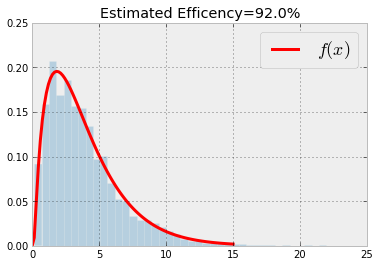

In [ ]:
hmax=h(x).max()
u1 = ch.rvs(5000) # samples from chi-square distribution
u2 = rand(5000)   # uniform random samples
idx = (u2 <= h(u1)/hmax)  # Rejection criterion

v = u1[idx]  # keep these only

fig,ax=subplots()
ax.hist(v,normed=1,bins=40,alpha=.3)
ax.plot(x,fx,'r',lw=3.,label='$f(x)$')
ax.set_title('Estimated Efficency=%3.1f%%'%(100*len(v)/len(u1)))
ax.legend(fontsize=18)

Using the $\chi^2$ distribution with the rejection method results in throwing away less than 10% of the generated samples compared with our prior example where we threw out at least 80% of the generated samples. Obviously, this way is much more computationally efficient and this is the kind of thing we are always looking for.

For completeness, here is the corresponding plot that shows the samples with the corresponding threshold $h(x)/h_{\max}$ that was used to select them.

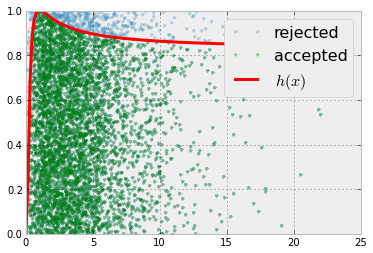

In [ ]:
fig,ax=subplots()
ax.plot(u1,u2,'.',label='rejected',alpha=.3)
ax.plot(u1[idx],u2[idx],'g.',label='accepted',alpha=.3)
ax.plot(x,h(x)/hmax,'r',lw=3.,label='$h(x)$')
ax.legend(fontsize=16) 

## Summary

In this section, we investigated how to generate random samples from a given distribution, beit discrete or continuous. For the continuouse case, the key issue was whether or not the cumulative density function had a continuous inverse. If not, we had to turn to the rejection method, and find an appropriate related density that we could easily sample from to use as part of a rejection threshold. Finding such a function is an art, but many families of probability densities have been studied over the years that already have fast sample-generators.

It is possible to go much deeper with the rejection method, but these involve careful partitioning of the domains and lots of special methods for separate domains and corner cases.  Nonetheless, all of these advanced techniques are still variations on the same fundamental theme we illustrated here.

## References

[Exploring Monte Carlo Methods by Dunn, 2011](http://books.google.com/books?id=ACTrrQk1UgoC&dq=Exploring+Monte+Carlo+Methods&source=gbs_navlinks_s)

[Continuous univariate distributions by Balakrishnan, 1995](http://books.google.com/books?id=0QzvAAAAMAAJ&dq=continuous+balakrishnan&hl=en&sa=X&ei=vzcuUtqvOYOKjAKr14BI&ved=0CC8Q6AEwAA)

[IPython Source Notebook](https://github.com/unpingco/Pig-in-the-Python/blob/master/Sampling_Monte_Carlo.ipynb)